In [1]:
!pip install -q torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00


This code installs the PyTorch library using pip, which is a package manager for Python.
 The exclamation mark at the beginning of the line indicates that this is a shell command,
  not a Python command. The "-q" flag is used to suppress the output of the installation process.

In [2]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

This code installs the necessary packages for using PyTorch Geometric library.


The first line %%capture is a Jupyter Notebook magic command that suppresses the output of the following cell.


The next three lines import the necessary packages, set the environment variable for the installed version of PyTorch, and ignore any Python warnings.


The next three lines use pip to install the torch-scatter, torch-sparse, and pytorch_geometric packages respectively. The -f flag specifies the URL of the package to be installed, which is hosted on the PyTorch Geometric website. The ${TORCH} syntax is used to reference the previously set environment variable for the installed version of PyTorch.


Overall, this code installs the necessary packages for using PyTorch Geometric library and suppresses the output of the installation process.

### Planetoid Cora Dataset
 Planetoid is a citation network dataset from Cora, CiteSeer, and PubMed. The nodes are documents with 1433-dimensional bag-of-words feature vectors, and the edges are citation links between research papers. There are 7 classes, and we will train the model to predict missing labels.

We will ingest the Planetoid Cora dataset, and row normalize the bag of words input features. After that, we will analyze the dataset and the first graph object.

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


This code imports the Planetoid dataset from the torch_geometric.datasets module and the NormalizeFeatures transform from the torch_geometric.transforms module.


Then, it creates an instance of the Planetoid dataset with the name Cora and applies the NormalizeFeatures transform to it. The dataset is stored in the dataset variable.


The code then prints out some information about the dataset, including the number of graphs, number of features, and number of classes.


Finally, the code gets the first graph object from the dataset and stores it in the data variable. The data variable can be used to access the features, labels, and edges of the graph.

**The Cora dataset has 2708 nodes, 10,556 edges, 1433 features, and 7 classes. The first object has 2708 train, validation, and test masks. We will use these masks to train and evaluate the model. **

This code snippet is not actually a code, but rather a description of a dataset called Cora. The dataset contains one graph with 2708 nodes, each with 1433 features. There are 7 classes in the dataset. The data is represented as a dictionary with the following keys:



x: a matrix of node features with shape (2708, 1433)

edge_index: a matrix of edge indices with shape (2, 10556)

y: a vector of node labels with shape (2708,)

train_mask: a binary vector indicating which nodes are used for training with shape (2708,)

val_mask: a binary vector indicating which nodes are used for validation with shape (2708,)

test_mask: a binary vector indicating which nodes are used for testing with shape (2708,)


This information is useful for understanding the structure and contents of the Cora dataset, which can be used for machine learning tasks such as node classification or link prediction.

In [4]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


This code defines a Graph Convolutional Network (GCN) model using the PyTorch Geometric library.


First, the necessary modules are imported: GCNConv from torch_geometric.nn and F from torch.nn.functional.


Then, a class called GCN is defined, which inherits from torch.nn.Module. The constructor method __init__ takes a parameter hidden_channels, which specifies the number of hidden channels in the GCN layers.


In the constructor, a random seed is set for reproducibility, and two GCN layers are defined using GCNConv. The first layer takes as input the number of features in the dataset (dataset.num_features) and the number of hidden channels, and the second layer takes as input the number of hidden channels and the number of classes in the dataset (dataset.num_classes).


The forward method takes as input the node features x and the edge indices edge_index, and applies the two GCN layers in sequence. Between the layers, a ReLU activation function is applied to the output of the first layer, and a dropout layer is applied with a probability of 0.5 to prevent overfitting.


Finally, an instance of the GCN class is created with hidden_channels=16, and the model is printed to show the structure of the two GCN layers.


# Visualizing Untrained GCN network
Let’s visualize node embeddings of untrained GCN networks using sklearn.manifold.TSNE and matplotlib.pyplot. It will plot a 7 dimension node embedding a 2D scatter plot.  

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

This code defines a function called visualize that takes in two arguments: h and color.


The first line %matplotlib inline is a magic command in Jupyter Notebook that allows the plots to be displayed inline in the notebook.


The second line imports the pyplot module from the matplotlib library, which is used for creating visualizations.


The third line imports the TSNE class from the sklearn.manifold module, which is used for dimensionality reduction.


The visualize function uses the TSNE class to reduce the dimensionality of the input h to 2 dimensions, and then plots the resulting 2D points using pyplot.scatter. The s parameter sets the size of the points, and the c parameter sets the color of the points based on the color argument. The cmap parameter sets the color map to use for the plot.


Finally, the plt.show() function is called to display the plot.

**We will evaluate the model then add training data to the untrained model to visualize various nodes and categories.**

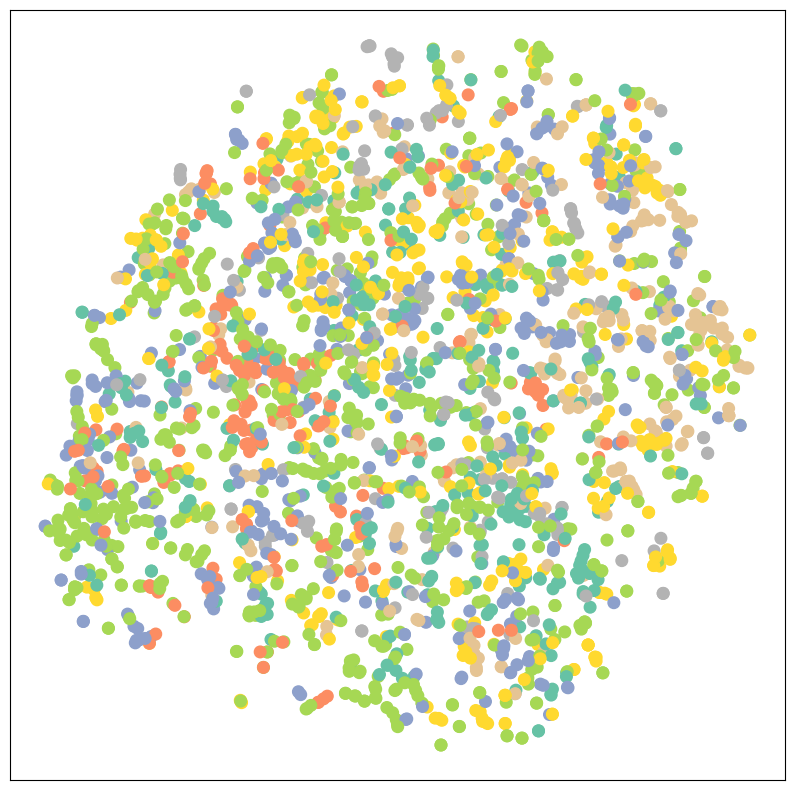

In [7]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

This code snippet is written in Python and is using PyTorch library.


The first line model.eval() sets the model to evaluation mode. This is important because during training, the model may use techniques like dropout or batch normalization which are not used during evaluation.


The second line out = model(data.x, data.edge_index) passes the input data data.x and the edge index data.edge_index to the model and gets the output out.


The third line visualize(out, color=data.y) is a function call that takes the output out and the target labels data.y and visualizes the output. The color parameter is used to color the nodes in the visualization based on their true label.


Overall, this code snippet is evaluating a PyTorch model on a given dataset and visualizing the output.

# Training GNN

We will train our model on 100 Epochs using Adam optimization and the Cross-Entropy Loss function.

In the train function, we have:

1.   Clear the gradient
2.   Performed a single forward pass
3.  Compute loss using training nodes
4.  Calculate gradient, and update the parameters




In the test function, we have:


1. Predicted node class
2. Extracted class label with the highest probability
3. Checked how many values have been predicted correctly
4. Creating accuracy ratio using a sum of correct predictions divided by a total number of nodes.

In [9]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


This code trains and tests a Graph Convolutional Network (GCN) model using the PyTorch library.


First, the GCN model is initialized with 16 hidden channels. Then, an Adam optimizer is created with a learning rate of 0.01 and weight decay of 5e-4. A cross-entropy loss function is also defined.


Next, two functions are defined: train() and test(). The train() function sets the model to training mode, clears the optimizer gradients, passes the input data through the model, calculates the loss using the cross-entropy loss function, backpropagates the loss, and updates the model parameters using the optimizer. The function returns the loss value. The test() function sets the model to evaluation mode, passes the input data through the model, calculates the accuracy of the model predictions on the test set, and returns the accuracy value.


Then, a loop is run for 100 epochs, where each epoch calls the train() function to train the model and prints the epoch number and loss value. After training, the test() function is called to evaluate the accuracy of the model on the test set.


Finally, the architecture of the GCN model is printed, which consists of two GATConv layers with different input and output dimensions and number of heads.

Model Evaluation
We will now evaluate the model on an unseen dataset using the test function, and as you can see, we got pretty good results on 81.5% accuracy.

In [10]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


We will now visualize the output embedding of a trained model to verify the results.




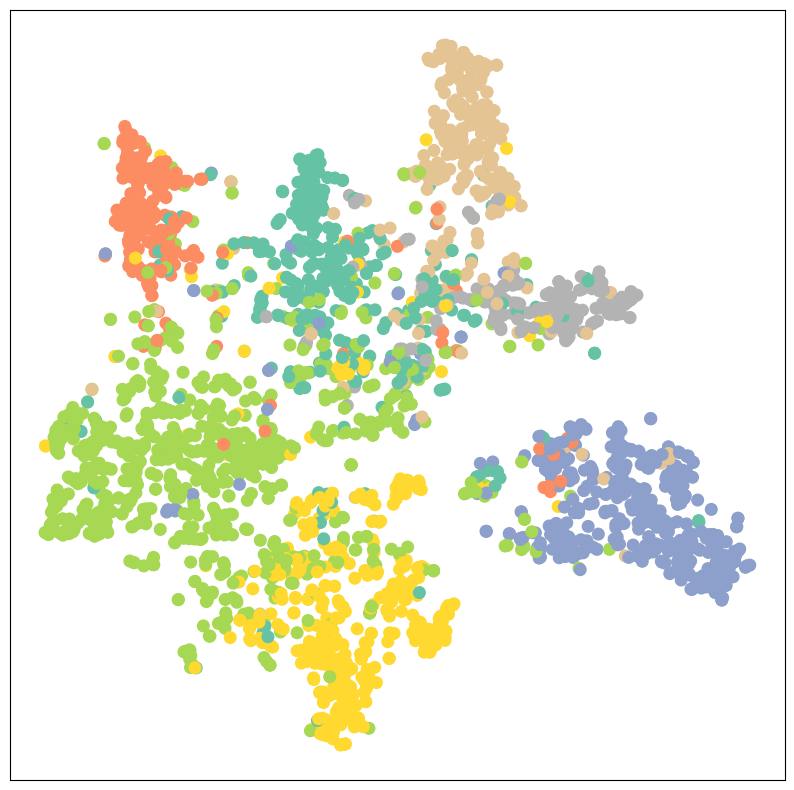

In [11]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

This code snippet is written in Python and is using PyTorch library.


The first line model.eval() sets the model to evaluation mode. This is important because during training, the model may use techniques like dropout or batch normalization which are not used during evaluation.


The second line out = model(data.x, data.edge_index) passes the input data data.x and the edge index data.edge_index to the model and gets the output out.


The third line visualize(out, color=data.y) is a function call that takes the output out and the target labels data.y and visualizes the output. The color parameter is used to color the nodes in the visualization based on their true label.


Overall, this code snippet is evaluating a PyTorch model on a given dataset and visualizing the output.

Training GATConv Model
In the second, we will replace GCNConv with GATConv layers. The Graph Attention Networks uses masked self-attentional layers to address the drawbacks of GCNConv and achieve state-of-the-art results.

You can also try other GNN layers and play around with optimizations, dropouts, and a number of hidden channels to achieve better performance.

In the code below, we have just replaced GCNConv with GATConv with 8 attention heads in the first layer and 1 in the second layer.

We will also set:

dropout rate to 0.6
hidden channels to 8
learning rate 0.005
We have modified the test function to find the accuracy of a specific mask (valid, test). It will help us print out validation and test scores during model training. We are also storing validation and test results to a plot line chart later.

**As we can see, the trained model has produced better clustering of nodes for the same category.**



## Training GATConv Model


In the second, we will replace GCNConv with GATConv layers. The Graph Attention Networks uses masked self-attentional layers to address the drawbacks of GCNConv and achieve state-of-the-art results.

You can also try other GNN layers and play around with optimizations, dropouts, and a number of hidden channels to achieve better performance.

In the code below, we have just replaced GCNConv with GATConv with 8 attention heads in the first layer and 1 in the second layer.

We will also set:

1. dropout rate to 0.6
2. hidden channels to 8
3. learning rate 0.005

We have modified the test function to find the accuracy of a specific mask (valid, test). It will help us print out validation and test scores during model training. We are also storing validation and test results to a plot line chart later.

In [12]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

This code trains a Graph Attention Network (GAT) model on a graph dataset using PyTorch Geometric library.


First, the necessary libraries are imported, including the GATConv module from torch_geometric.nn. Then, a GAT class is defined as a subclass of torch.nn.Module. The class takes two arguments: hidden_channels and heads, which are used to define the two GATConv layers in the constructor. The forward method of the class applies dropout to the input features, passes them through the two GATConv layers with ELU activation function, and returns the output.


Next, an instance of the GAT class is created with hidden_channels=8 and heads=8, and printed to the console. An optimizer (Adam) and a loss function (CrossEntropyLoss) are defined for training the model.


Two functions are defined for training and testing the model. The train function sets the model to training mode, performs forward and backward passes on the training data, and updates the model parameters using the optimizer. The test function sets the model to evaluation mode, computes the accuracy of the model on the validation or test set, and returns the accuracy.


Finally, the model is trained for 100 epochs using a for loop. In each epoch, the train function is called to update the model parameters, and the test function is called to compute the accuracy on the validation and test sets. The validation and test accuracies are stored in two lists, and printed to the console at the end of each epoch.

As we can observe, our model didn’t perform better than GCNConv. It requires hyperparameter optimization or more Epochs to achieve state-of-the-art results.

## Model Evaluation
In the evaluation part, we visualize validation and testing scores using matplotlib.pyplot’s line plot.  

This code imports the NumPy library and creates a figure with a size of 12 by 8 using the plt.figure() function from the Matplotlib library. It then plots two lines using the plt.plot() function, one for the validation accuracy and one for the testing accuracy. The x-axis is labeled as "Epochs" and the y-axis is labeled as "Accuracy". The title of the plot is "GATConv" and a legend is added to the plot with the labels "Validation accuracy" and "Testing accuracy". The plot is saved as a PNG file named "gat_loss.png" using the plt.savefig() function and displayed using the plt.show() function.

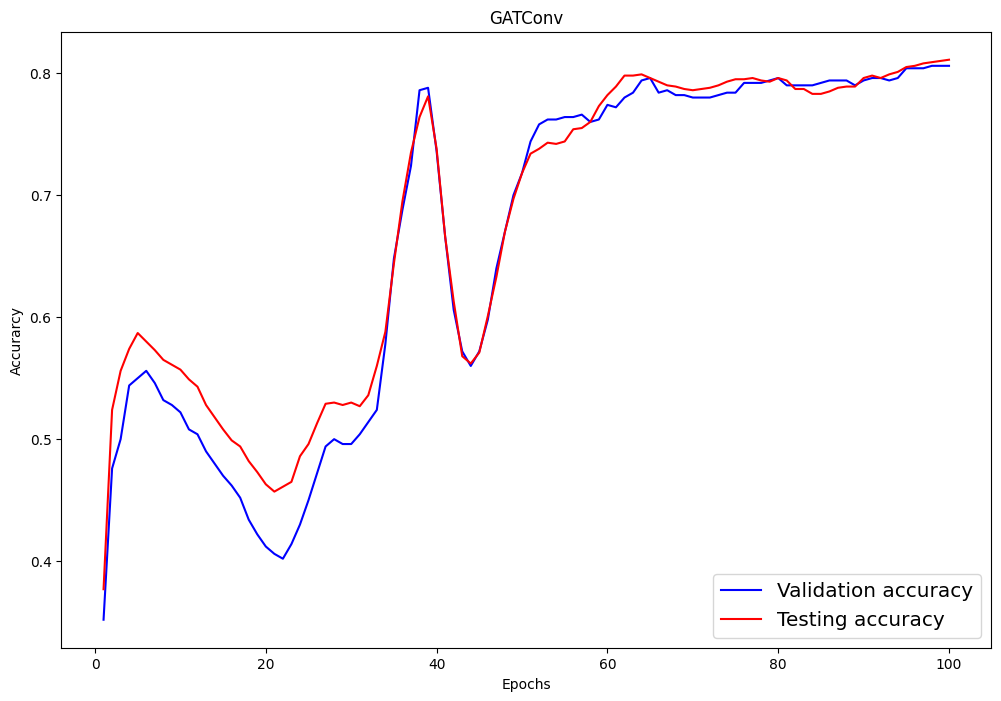

In [13]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

Again, let’s visualize the node clustering of the GATConv model.




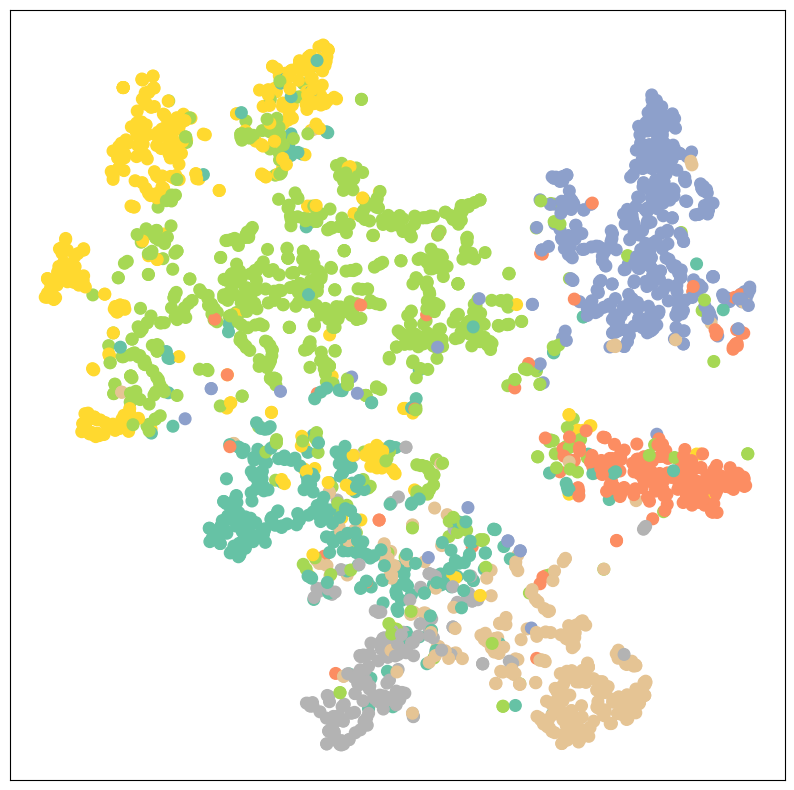

In [14]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

**We can reduce overfitting by adding a second validation dataset and improve model performance by experimenting with various GCN layers from pytoch_geometric. **

This code snippet is written in Python and is using PyTorch library.


The first line model.eval() sets the model to evaluation mode. This is important because during training, the model may use techniques like dropout or batch normalization which are not used during evaluation.


The second line out = model(data.x, data.edge_index) passes the input data data.x and the edge index data.edge_index to the model and gets the output out.


The third line visualize(out, color=data.y) is a function call that takes the output out and the target labels data.y and visualizes the output. The color parameter is used to color the nodes in the visualization based on their true label.


Overall, this code snippet is evaluating a PyTorch model on a given dataset and visualizing the output.

As we can see, the GATConv layer has produced the same results in clustering on the same category of nodes.